In [1]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import animation, rc
rc('animation', html='html5')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [261]:
# Magnetic field, electric field
B = np.array((0,0,1))
E = np.array((0,0,0))

In [262]:
def lorentz(X, t, q_over_m):
        """
        The equations of motion for the Lorentz force on a particle with
        q/m given by q_over_m. X=[x,y,z,vx,vy,vz] defines the particle's
        position and velocity at time t: F = ma = (q/m)[E + v×B].
        
        """
        
        v = X[3:]
        drdt = v
        dvdt = q_over_m * (E + np.cross(v, B))
        return np.hstack((drdt, dvdt))

In [265]:
def larmor(q, m, v0):
    """Calculate the Larmor (cyclotron) radius.

    rho = m.v_perp / (|q|B) where m is the particle's mass,
    q is its charge, B is the magnetic field strength and
    v_perp is its instantaneous speed perpendicular to the
    magnetic field, **B**.

    """

    B_sq = B @ B
    v0_par = (v0 @ B) * B / B_sq
    v0_perp = v0 - v0_par
    v0_perp_abs = np.sqrt( v0_perp @ v0_perp)
    return m * v0_perp_abs / np.abs(q) / np.sqrt(B_sq)

def calc_trajectory(q, m, r0=None, v0 = np.array((1,0,1))):
    """Calculate the particle's trajectory.
    
    q, m are the particle charge and mass;
    r0 and v0 are its initial position and velocity vectors.
    If r0 is not specified, it is calculated to be the Larmor
    radius of the particle, and particles with different q, m
    are placed so as have a common guiding centre (for E=0).
    
    """
    if r0 is None:
        rho = larmor(q, m, v0)
        vp = np.array((v0[1],-v0[0],0))
        r0 = -np.sign(q) * vp * rho
    # Final time, number of time steps, time grid.
    tf = 50
    N = 10 * tf
    t = np.linspace(0, tf, N)
    # Initial positon and velocity components.
    X0 = np.hstack((r0, v0))
    # Do the numerical integration of the equation of motion.
    X = odeint(lorentz, X0, t, args=(q/m,))
    return X

In [270]:
def setup_axes(ax):
    """Style the 3D axes the way we want them."""
    
    # Gotta love Matplotlib: this is how to indicate a right-handed
    # coordinate system with the x, y, and z axes meeting at a point.
    ax.yaxis._axinfo['juggled'] = (1,1,2)
    ax.zaxis._axinfo['juggled'] = (1,2,0)
    # Remove axes ticks and labels, the grey panels and the gridlines.
    for axis in ax.w_xaxis, ax.w_yaxis, ax.w_zaxis:
        for e in axis.get_ticklines() + axis.get_ticklabels():
            e.set_visible(False) 
        axis.pane.set_visible(False)
        axis.gridlines.set_visible(False)
    # Label the x and z axes only.
    ax.set_xlabel('x', labelpad=-10, size=16)
    ax.set_zlabel('z', labelpad=-10, size=16)

In [282]:
def plot_trajectories(trajectories):
    """Produce a static plot of the trajectories.
    
    trajectories should be a sequence of (n,3) arrays representing
    the n timepoints over which the (x,y,z) coordinates of the
    particle are given.
    
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for X in trajectories:
        ax.plot(*X.T[:3])
    setup_axes(ax)
    # Plot a vertical line through the origin parallel to the
    # magnetic field.
    zmax = np.max(np.max([X.T[2] for X in trajectories]))
    ax.plot([0,0],[0,0],[0,zmax],lw=2,c='gray')
    plt.show()

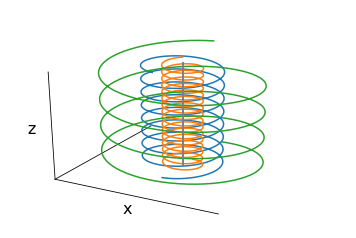

In [284]:
# Test the static plot.

# Electron mass and charge
me, qe = 1, -1
v0 = np.array((1,0,1))
X = calc_trajectory(qe, me)
X2 = calc_trajectory(-2*qe, me)
X3 = calc_trajectory(-qe, 2*me)
plot_trajectories([X, X2, X3])

In [285]:
# charges and masses of the electron (e) and ion (i)
qe, me = -1, 1
qi, mi = 1, 3
# Calculate the trajectories for the particles (which don't interact) by
# numerical integration of their equations of motion.
Xe = calc_trajectory(qe, me)
Xi = calc_trajectory(qi, mi)

def init():
    """Initialize the trajectory animation."""
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # The axis of the magentic field
    ax.plot([0,0],[0,0],[0,50],lw=2,c='gray')
    # Electron motion, ion motion
    lne, = ax.plot(*Xe.T[:3])
    lni, = ax.plot(*Xi.T[:3])
    # The particles instantaneous positions are indicated by circles from 
    # a scatter plot, scaled according to particle mass. depthshade=0
    # ensures that the colour doesn't fade as the the particle's distance
    # from the observer increases.
    SCALE = 40
    particles = ax.scatter(*np.vstack((Xe[0][:3], Xi[0][:3])).T,
                           s=(me*SCALE, mi*SCALE),
                           c=('tab:blue', 'tab:orange'), depthshade=0)
    # Some tidying up and labelling of the axes.
    setup_axes(ax)
    return fig, ax, lne, lni, particles

def animate(i):
    """The main animation function, called for each frame."""
    
    def animate_particle(X, ln, i):
        """Plot the trajectory of a particle up to step i."""
        
        ln.set_data(X[:i,0], X[:i,1])
        ln.set_3d_properties(X[:i,2])
        particles._offsets3d = np.vstack((Xe[i][:3], Xi[i][:3])).T
    animate_particle(Xe, lne, i)
    animate_particle(Xi, lni, i)

fig, ax, lne, lni, particles = init()
anim = animation.FuncAnimation(fig, animate, frames=500, interval=10, blit=False)

In [286]:
from IPython.display import HTML
HTML(anim.to_html5_video())